### 1. Environment Settings

#### 1.1 Import Library

In [1]:
import pandas as pd 
import numpy as np
import random
import os
import argparse
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel

#### 1.2 Setting Default Value

In [2]:
default_path = os.getcwd()
data_path = os.path.join(default_path, '../data')
base_model = os.path.join(default_path, '../base-model')
config_path = os.path.join(default_path, '../config')
log_path = os.path.join(default_path, '../log')
config_file = "bert-base.json"

#### 1.3 Load Dataset 

In [3]:
X_train = pd.read_csv(os.path.join(data_path, 'bws_bin_train.csv'))
X_dev = pd.read_csv(os.path.join(data_path, 'bws_bin_val.csv'))

#### 1.4 Load Pretrained model & tokenizer 

In [8]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model, 'bert-base'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model, 'bert-base', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(base_model, 'bert-base'), config=config)

Some weights of the model checkpoint at F:\AuD\base-model\bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
config.max_position_embeddings = 128
config.max_position_embeddings

128

#### 1.5 setting training args & config 

In [9]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [10]:
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

### 2. Define Class

In [11]:
training_config.pad = 'max_length'
training_config.num_epochs = 500

In [12]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [13]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                # print('input label 오류')
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [14]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [15]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        # print(f'logits: {len(logits)}, {len(logits[0])}')
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        # print(f'score: {score}')
        return score 

In [16]:
class BertTrainer():
    def __init__(self, config, training_config, model, train_dataloader, eval_dataloader):
        self.config = config
        self.training_config = training_config
        self.model = model
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        
    def set_seed(self):
        random.seed(self.training_config.seed)
        np.random.seed(self.training_config.seed)
        torch.manual_seed(self.training_config.seed)
        if not self.training_config.no_cuda and torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.training_config.seed)
    
    def train(self):
        global_step = 0; nb_eval_steps = 0
        train_rmse = []; eval_rmse = []
        t_total = len(self.train_dataloader) // self.training_config.gradient_accumulation_steps * self.training_config.num_epochs

        optimizer = AdamW(self.model.parameters(), lr=self.training_config.learning_rate, eps=self.training_config.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * self.training_config.warmup_proportion), \
                                                    num_training_steps=t_total)
        
        criterion = RMSELoss
        # criterion = nn.MSELoss()
        best_loss = 9999 
        
        self.model.zero_grad()
        for epoch in range(int(self.training_config.num_epochs)):
            train_loss = 0.0; eval_loss = 0.0 
            
            for step, batch in enumerate(self.train_dataloader):
                self.model.train()
                batch = tuple(t.to(self.training_config.device) for t in batch)
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                # print(f'output: {type(outputs)}, {outputs.squeeze}')
                label = batch[3]
                # print(f'label: {label}')
                # print(f'output: {outputs}, {outputs.squeeze()}')
                loss = criterion(outputs.squeeze(), batch[3].type_as(outputs))
                loss.backward()
                
                train_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.training_config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                
                self.model.zero_grad()
            
            print(f'epoch: {epoch + 1} done, train_loss: {train_loss / len(self.train_dataloader)}')
            train_rmse.append(train_loss / len(self.train_dataloader))

            for step2, batch2 in enumerate(self.eval_dataloader):
                self.model.eval()
                batch2 = tuple(t.to(self.training_config.device) for t in batch2)

                with torch.no_grad():
                    inputs = {
                        "input_ids": batch2[0],
                        "attention_mask": batch2[1],
                        "token_type_ids": batch2[2],
                    }
                    label2 = batch2[3]
                    outputs = self.model(**inputs)
                    tmp_eval_loss = criterion(outputs.squeeze(), label2.type_as(outputs))
                    eval_loss += tmp_eval_loss.mean().item()
                    
                nb_eval_steps += 1

            eval_loss = eval_loss / nb_eval_steps
            eval_rmse.append(eval_loss)
            if eval_loss < best_loss:
                best_loss = eval_loss
                es = 0
                print(f'save best loss state model & log(epoch {epoch + 1})')
                # self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_{epoch}.pt'))
            else:
                es += 1
                print("Counter {} of 5".format(es))

            if es > 4:
                print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", eval_loss, "...")
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bin_best.pt'))
                break
        self.save_log(train_rmse, eval_rmse, epoch+1)
        return train_rmse, eval_rmse
            
    def save_log(self, train_mse, eval_mse, epoch):
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(train_mse, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(eval_mse, f, pickle.HIGHEST_PROTOCOL)  
    
    def save_model(self, model_name):
        torch.save(self.model.state_dict(), model_name)

### 3. Model Train

In [17]:
X_train.label.unique()

array([0, 1], dtype=int64)

In [18]:
train_file = BertDataset(X_train)
val_file = BertDataset(X_dev)

In [19]:
len(train_file), len(val_file)

(1152, 128)

In [22]:
bert_processor = BertProcessor(config, training_config, tokenizer)

In [23]:
train_dataset = bert_processor.convert_data(train_file)
val_dataset = bert_processor.convert_data(val_file)

In [24]:
train_sampler = bert_processor.shuffle_data(train_dataset, 'train')
val_sampler = bert_processor.shuffle_data(val_dataset, 'eval')

In [25]:
train_dataloader = bert_processor.load_data(train_dataset, train_sampler)
val_dataloader = bert_processor.load_data(val_dataset, val_sampler)

In [26]:
len(train_dataloader), len(val_dataloader)

(144, 16)

In [27]:
model_reg = BertRegressor(config, model).to(training_config.device)  

In [28]:
bert_trainer = BertTrainer(config, training_config, model_reg, train_dataloader, val_dataloader)

In [162]:
train_mse, eval_mse = bert_trainer.train()

epoch: 1 done, train_loss: 0.18117803582368816
save best loss state model & log(epoch 1)
epoch: 2 done, train_loss: 0.1133000250124075
save best loss state model & log(epoch 2)
epoch: 3 done, train_loss: 0.09480603488729052
save best loss state model & log(epoch 3)
epoch: 4 done, train_loss: 0.08484047359922489
save best loss state model & log(epoch 4)
epoch: 5 done, train_loss: 0.07431942639460466
save best loss state model & log(epoch 5)
epoch: 6 done, train_loss: 0.06989943554153091
save best loss state model & log(epoch 6)
epoch: 7 done, train_loss: 0.06578074270218526
save best loss state model & log(epoch 7)
epoch: 8 done, train_loss: 0.0572296899966966
save best loss state model & log(epoch 8)
epoch: 9 done, train_loss: 0.04857259205787219
save best loss state model & log(epoch 9)
epoch: 10 done, train_loss: 0.04907277745761625
Counter 1 of 5
epoch: 11 done, train_loss: 0.045805324844325875
save best loss state model & log(epoch 11)
epoch: 12 done, train_loss: 0.0438762084868805

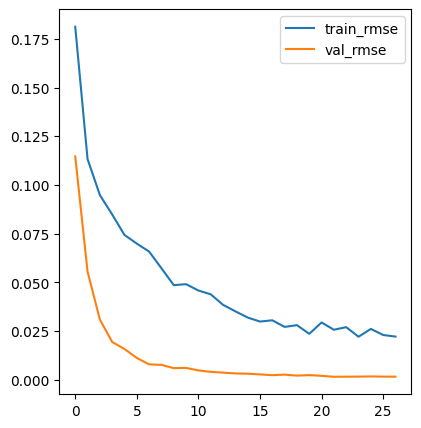

In [163]:
num_epochs = list(range(len(train_mse)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_mse))), train_mse, label='train_rmse')
plt.plot(list(range(len(eval_mse))), eval_mse, label='val_rmse')

plt.legend()
plt.show()